In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
#from sqlalchemy import extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
df_queryDates = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).all())
# Calculate the date 1 year ago from the last data point in the database
df_queryDates["date"] = pd.to_datetime(df_queryDates['date'])
last_date = df_queryDates["date"].max().date()
year_before_last_date = (last_date - dt.timedelta(days=365))

print(str(last_date), str(year_before_last_date))

2017-08-23 2016-08-23


In [37]:
# Perform a query to retrieve the data and precipitation scores
df_precipitation = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
                                filter(Measurement.date >= year_before_last_date).\
                                order_by(Measurement.date).all())
# Save the query results as a Pandas DataFrame and set the index to the date column
df_precip = pd.DataFrame(df_precipitation).dropna()
df_precip['date'] = pd.to_datetime(df_precip['date'])
df_precip = df_precip.set_index('date')

# Sort the dataframe by date
#df_precipitation.sort_index
df_precip.head(5)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


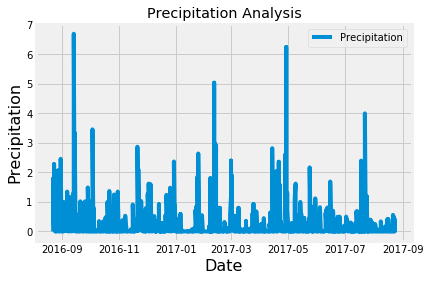

In [55]:
# Use Pandas Plotting with Matplotlib to plot the data
#plt.figure(figsize=(14,8))
plt.plot(df_precip.index, df_precip['prcp'],label='Precipitation')

plt.title("Precipitation Analysis")
plt.ylabel('Precipitation', fontsize = 16)
plt.xlabel('Date', fontsize = 16)
plt.legend(loc='best')
plt.show()

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
import pprint
#df_precipitation.set_index('date')
df_precipitation.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [57]:
# Design a query to show how many stations are available in this dataset?
df_uniqueStations = pd.DataFrame(session.query(Measurement.station,Measurement.tobs).all())
df_uniqueStations.set_index('station')

stations = df_uniqueStations.station.nunique()
print(F"There are {stations} stations available in this dataset")


There are 9 stations available in this dataset


In [69]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#df_station= df_station.set_index('station')
df_activeStations= pd.DataFrame(session.query(Measurement.station, func.count(Measurement.station).label('count')).\
                                  group_by(Measurement.station).all())
df_activeStations = df_activeStations.sort_values('count', ascending=False)
df_activeStations

,station,count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = df_activeStations['station'].iloc[0]
most_active_station

'USC00519281'

In [85]:
df_mostActiveStationSumm= pd.DataFrame(session.query(Measurement.station, Measurement.tobs).\
                                              filter(Measurement.station == most_active_station).\
                                              all())
#df_mostActiveStationSumm

In [86]:
minTemp = df_mostActiveStationSumm['tobs'].min()
maxTemp = df_mostActiveStationSumm['tobs'].max()
AvgTemp = df_mostActiveStationSumm['tobs'].mean()
print(minTemp, maxTemp, AvgTemp)

54.0 85.0 71.66378066378067


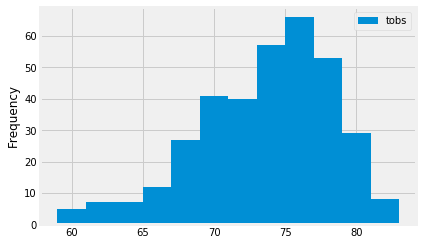

In [87]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_activeStationPast12Month= pd.DataFrame(session.query(Measurement.date, Measurement.tobs).\
                                filter(Measurement.station == most_active_station).\
                                filter(Measurement.date >= year_before_last_date).all())
#df_activeStationPast12Month
df_activeStationPast12Month.plot.hist(bins = 12)


In [88]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """#TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [147]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
df_prev_year = calc_temps('2016-02-28', '2016-03-05')
df_prev_year

[(62.0, 69.88636363636364, 80.0)]

Text(0, 0.5, 'Temp (F)')

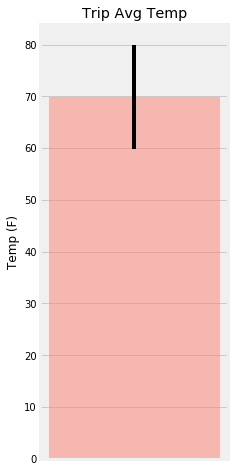

In [148]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,8))
plt.bar(0,df_prev_year[0][1], yerr=(df_prev_year[0][2] - df_prev_year[0][1]) , color = 'salmon', alpha =0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')



In [149]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Station.name,
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                        group_by(Measurement.station).\
                        join(Station, Measurement.station == Station.station).\
                        filter(Measurement.date >= start_date).\
                        filter(Measurement.date <= end_date).\
                        order_by(Measurement.prcp.desc()).all()

rainfall('2016-02-28', '2016-03-05')

[('USC00513117', 'KANEOHE 838.1, HI US', 0.0, 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.0,
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.0,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.0,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.0,
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [150]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
